In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15782, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15782 (delta 9), reused 25 (delta 6), pack-reused 15743 (from 1)
Receiving objects: 100% (15782/15782), 6.36 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (11505/11505), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your env

In [ ]:

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YohwIPr0iQFNeATEe9Hc")
project = rf.workspace("telkom-university-mfinb").project("neudet-steel-surface-defects")
version = project.version(4)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to NEUDET-Steel-Surface-Defects-4 in coco:: 100%|██████████| 1807/1807 [00:00<00:00, 5276.43it/s]


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/NEUDET-Steel-Surface-Defects-4/train/_annotations.coco.json", "/content/NEUDET-Steel-Surface-Defects-4/train")
register_coco_instances("my_dataset_test", {}, "/content/NEUDET-Steel-Surface-Defects-4/valid/_annotations.coco.json", "/content/NEUDET-Steel-Surface-Defects-4/valid")


In [ ]:
/content/NEUDET-Steel-Surface-Defects-4/train

WARNING [10/10 12:00:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 12:00:35 d2.data.datasets.coco]: Loaded 1259 images in COCO format from /content/NEUDET-Steel-Surface-Defects-4/train/_annotations.coco.json


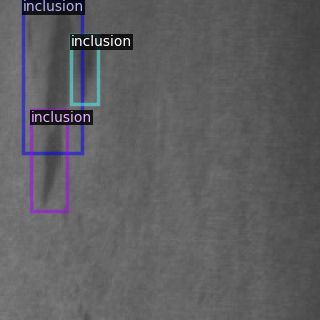

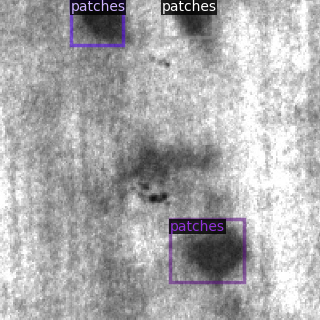

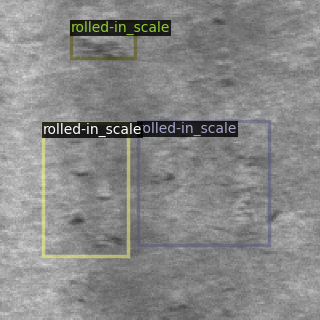

In [ ]:

#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
print(MetadataCatalog.get("my_dataset_train").get("thing_classes"))

['steel-surface-defects', 'crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [ ]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/10 12:01:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 196MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/10 12:01:27 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


[10/10 12:01:37 d2.utils.events]:  eta: 0:02:27  iter: 19  total_loss: 2.869  loss_cls: 2.001  loss_box_reg: 0.6414  loss_rpn_cls: 0.2064  loss_rpn_loc: 0.02877    time: 0.2945  last_time: 0.2104  data_time: 0.0195  last_data_time: 0.0047   lr: 9.7405e-05  max_mem: 1737M
[10/10 12:01:45 d2.utils.events]:  eta: 0:02:09  iter: 39  total_loss: 1.914  loss_cls: 0.9214  loss_box_reg: 0.8674  loss_rpn_cls: 0.06793  loss_rpn_loc: 0.02261    time: 0.2875  last_time: 0.3188  data_time: 0.0078  last_data_time: 0.0051   lr: 0.00019731  max_mem: 1737M
[10/10 12:01:51 d2.utils.events]:  eta: 0:02:04  iter: 59  total_loss: 1.574  loss_cls: 0.7413  loss_box_reg: 0.7913  loss_rpn_cls: 0.02739  loss_rpn_loc: 0.01767    time: 0.2860  last_time: 0.2462  data_time: 0.0143  last_data_time: 0.0046   lr: 0.0002972  max_mem: 1737M
[10/10 12:01:57 d2.utils.events]:  eta: 0:01:58  iter: 79  total_loss: 1.591  loss_cls: 0.6869  loss_box_reg: 0.8021  loss_rpn_cls: 0.02531  loss_rpn_loc: 0.02032    time: 0.2851  l

[09/24 09:45:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[10/10 12:04:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 30.0859,   1.2506, 600.7751, 581.0305],
        [341.3105,   6.0036, 441.3994, 101.3000]], device='cuda:0')), scores: tensor([0.8576, 0.5289], device='cuda:0'), pred_classes: tensor([4, 3], device='cuda:0')])}


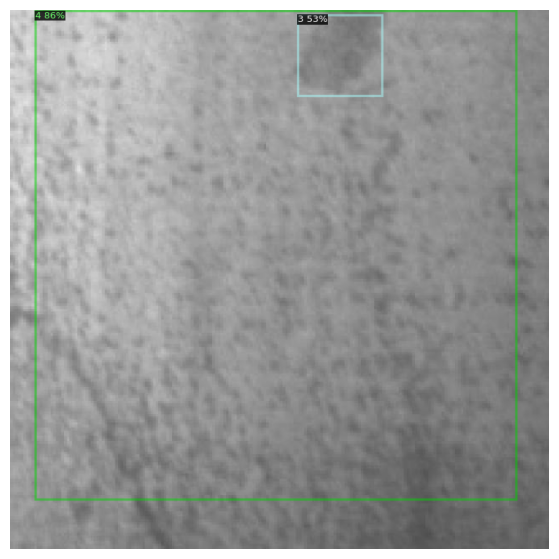

{'instances': Instances(num_instances=10, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 40.7506,  22.8614, 608.7331, 334.3975],
        [ 62.0382, 428.7723, 607.1794, 616.1511],
        [ 12.9973,  71.3553, 372.2735, 298.9778],
        [ 41.9412, 219.3521, 595.0236, 572.0322],
        [ 33.0249,  15.7366, 487.7890, 173.7831],
        [ 30.9865, 361.0028, 391.5239, 539.0329],
        [240.1360,  24.3945, 595.5825, 183.6726],
        [ 15.2103, 223.7335, 367.6781, 489.4958],
        [257.9378,   4.1222, 625.0000,  96.5848],
        [298.5339, 383.8476, 611.0636, 564.0054]], device='cuda:0')), scores: tensor([0.7245, 0.6766, 0.6607, 0.6210, 0.6027, 0.6002, 0.5678, 0.5424, 0.5173,
        0.5068], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


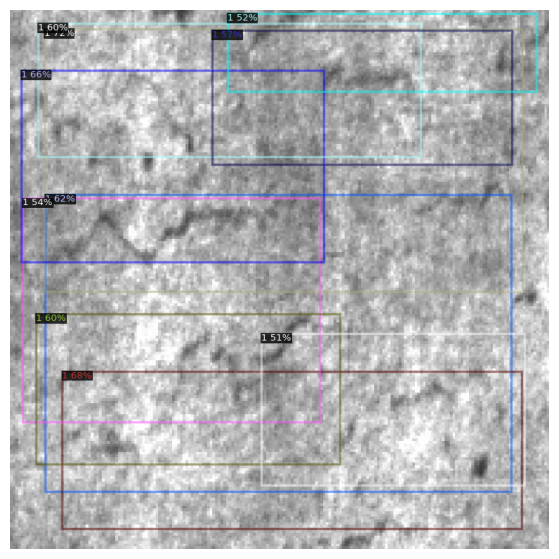

{'instances': Instances(num_instances=6, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[328.3799,   0.0000, 535.0565, 269.8608],
        [ 33.6994,   3.7721, 245.1017, 187.6187],
        [ 53.1590, 241.4785, 508.7620, 520.6588],
        [277.1483,   0.0000, 513.7438, 424.8050],
        [329.8353,   0.0000, 528.4426,  97.9963],
        [138.3225,  59.2865, 515.6580, 612.8687]], device='cuda:0')), scores: tensor([0.7926, 0.7289, 0.6447, 0.5757, 0.5487, 0.5176], device='cuda:0'), pred_classes: tensor([5, 5, 5, 5, 5, 5], device='cuda:0')])}


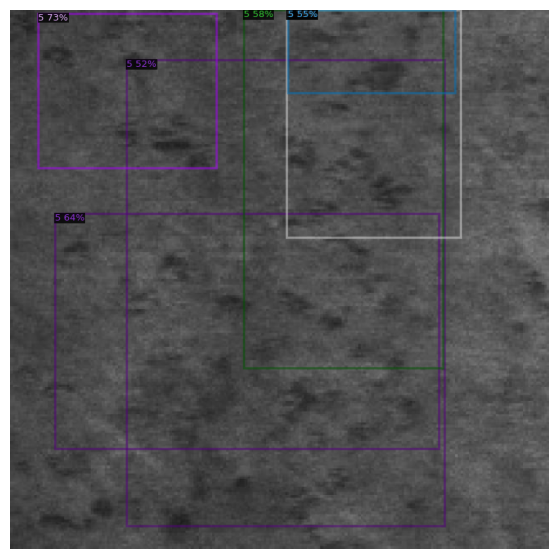

{'instances': Instances(num_instances=5, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 82.6616,  42.0153, 117.0814, 113.6474],
        [388.8814, 132.2323, 459.0619, 563.9643],
        [ 69.6733,  40.4658, 120.1434, 142.3846],
        [521.3181, 356.4546, 552.8168, 436.1163],
        [ 59.1701, 193.0968, 121.6803, 599.5230]], device='cuda:0')), scores: tensor([0.8208, 0.6359, 0.5610, 0.5547, 0.5225], device='cuda:0'), pred_classes: tensor([2, 2, 2, 2, 2], device='cuda:0')])}


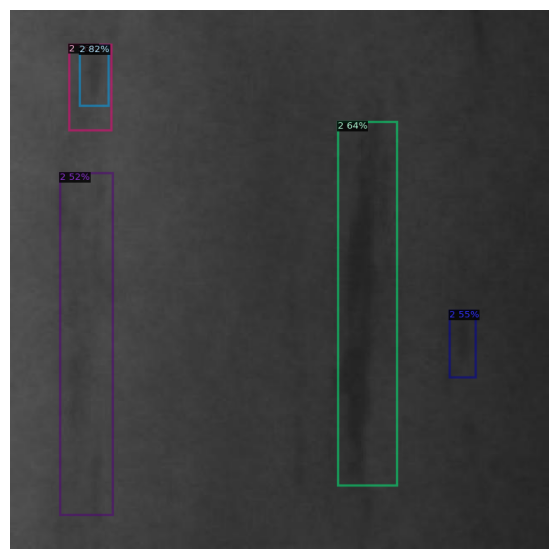

{'instances': Instances(num_instances=6, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 63.0934,   0.0000, 311.0597, 219.8712],
        [ 53.7790,   0.0000, 357.4041, 390.0516],
        [453.3063, 241.0768, 572.9284, 369.7788],
        [146.7859, 382.2344, 335.2523, 580.9482],
        [140.2341, 121.1497, 357.7978, 392.8847],
        [125.7986,  82.4171, 371.5440, 588.6159]], device='cuda:0')), scores: tensor([0.8066, 0.7988, 0.6685, 0.6119, 0.6011, 0.5205], device='cuda:0'), pred_classes: tensor([5, 5, 5, 5, 5, 5], device='cuda:0')])}


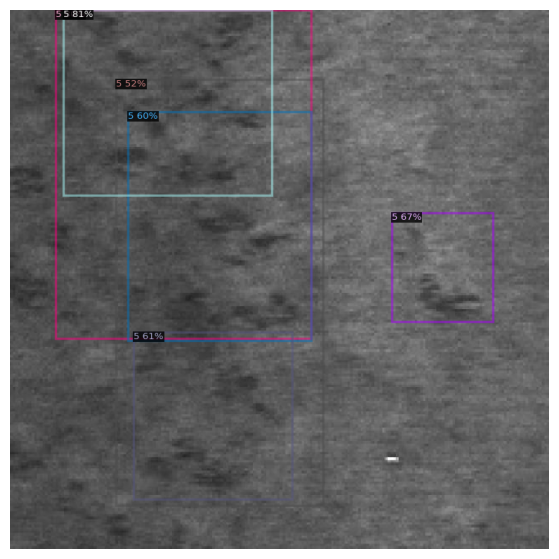

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[230.2802,  66.6494, 278.0797, 189.7899],
        [244.5595, 242.3201, 306.9470, 577.6895]], device='cuda:0')), scores: tensor([0.8484, 0.7486], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


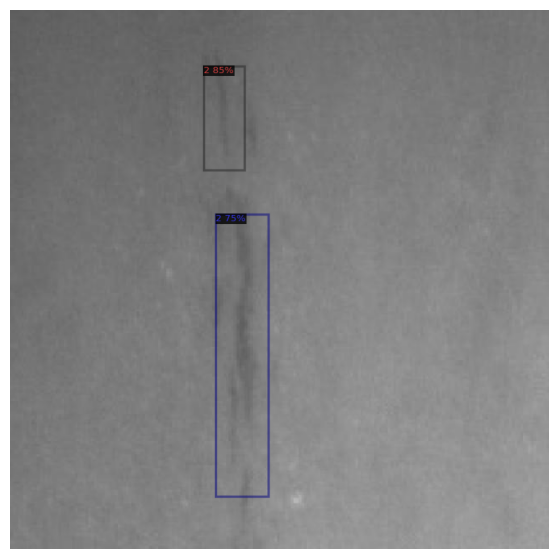

{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[187.8086, 173.0146, 378.0352, 529.5760],
        [231.2410, 395.5589, 562.4402, 588.1110],
        [136.2819, 181.2940, 357.2556, 396.6942],
        [183.2893, 334.0313, 353.0057, 557.6205]], device='cuda:0')), scores: tensor([0.6278, 0.5699, 0.5230, 0.5073], device='cuda:0'), pred_classes: tensor([5, 5, 5, 5], device='cuda:0')])}


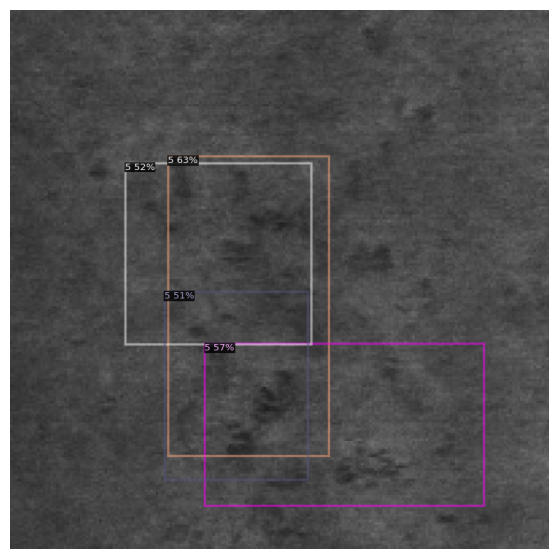

{'instances': Instances(num_instances=6, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[218.8621, 438.7461, 409.5658, 601.1500],
        [ 18.8962,  96.8823, 195.6721, 308.1138],
        [ 44.5293,  10.0465, 355.0656, 186.7582],
        [440.7737, 208.8653, 625.6989, 394.3322],
        [ 32.6600, 426.9551, 396.0710, 603.2446],
        [ 30.9118,  17.1918, 253.6429, 296.3049]], device='cuda:0')), scores: tensor([0.6763, 0.6225, 0.6138, 0.6103, 0.5391, 0.5008], device='cuda:0'), pred_classes: tensor([5, 5, 5, 5, 5, 5], device='cuda:0')])}


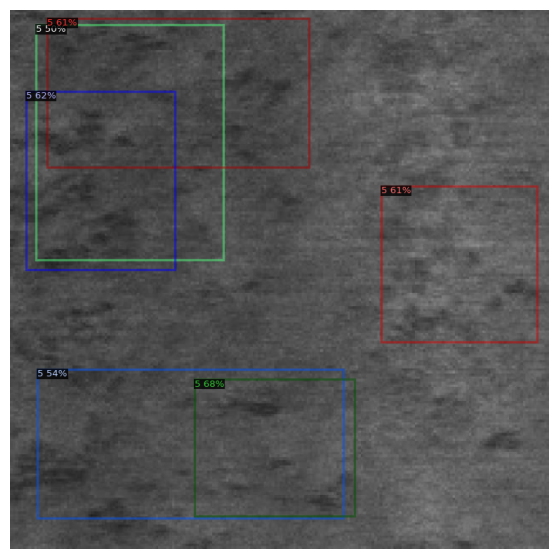

{'instances': Instances(num_instances=8, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[5.5542e+02, 5.1345e-01, 6.1507e+02, 4.4670e+01],
        [4.3804e+01, 3.0362e+01, 6.1130e+02, 3.1507e+02],
        [1.1123e+02, 3.0338e+02, 6.1295e+02, 5.5595e+02],
        [5.0253e+01, 7.6849e+00, 6.1855e+02, 1.6038e+02],
        [5.9058e+01, 1.1511e+02, 3.7027e+02, 2.6641e+02],
        [6.3246e+01, 1.8220e+02, 4.2054e+02, 3.2898e+02],
        [5.0083e+02, 1.6370e+02, 6.2517e+02, 2.7724e+02],
        [9.7357e+01, 4.2426e+02, 6.2232e+02, 5.9904e+02]], device='cuda:0')), scores: tensor([0.7777, 0.7310, 0.7236, 0.6412, 0.6106, 0.5716, 0.5468, 0.5273],
       device='cuda:0'), pred_classes: tensor([3, 1, 1, 1, 1, 1, 3, 1], device='cuda:0')])}


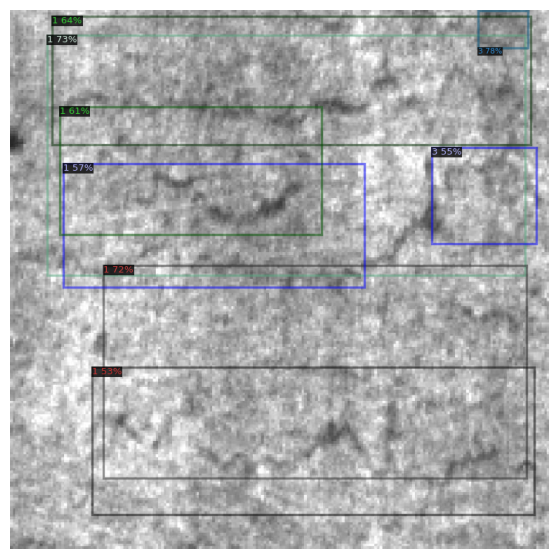

{'instances': Instances(num_instances=10, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 42.3538, 240.7948, 606.6673, 558.7874],
        [ 68.0427,  29.3210, 610.9316, 262.9693],
        [ 49.5683,   6.5171, 610.9614, 116.8777],
        [ 22.4793,   8.7096, 246.0229, 148.3305],
        [ 30.7897, 436.3853, 603.2283, 610.0395],
        [286.0340, 338.3580, 619.3311, 575.6740],
        [263.9146,  17.5829, 626.2635, 220.2146],
        [507.6624, 309.3261, 629.6946, 440.4105],
        [110.2155,  67.2144, 592.1030, 471.7323],
        [274.1522, 239.5564, 616.9684, 507.2168]], device='cuda:0')), scores: tensor([0.7297, 0.6899, 0.6858, 0.5941, 0.5698, 0.5594, 0.5378, 0.5337, 0.5316,
        0.5140], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 3, 1, 1], device='cuda:0')])}


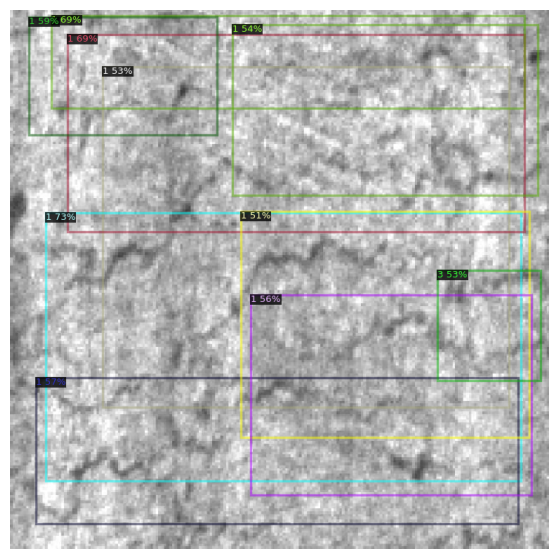

{'instances': Instances(num_instances=9, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[352.5692,   0.0000, 563.5519, 232.1055],
        [319.0489, 283.3835, 632.0034, 583.9225],
        [ 63.8705, 410.2461, 334.9163, 616.7504],
        [112.6927, 348.1059, 619.9471, 609.7526],
        [506.7237, 284.0074, 640.0000, 411.1409],
        [293.1202,   0.0000, 561.6010, 115.6957],
        [ 84.5928, 109.6051, 363.6392, 330.0140],
        [ 87.4199, 138.3198, 559.6289, 605.5889],
        [114.7850,   9.1887, 580.8631, 235.6770]], device='cuda:0')), scores: tensor([0.8280, 0.8152, 0.7230, 0.6943, 0.6030, 0.5979, 0.5884, 0.5422, 0.5099],
       device='cuda:0'), pred_classes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')])}


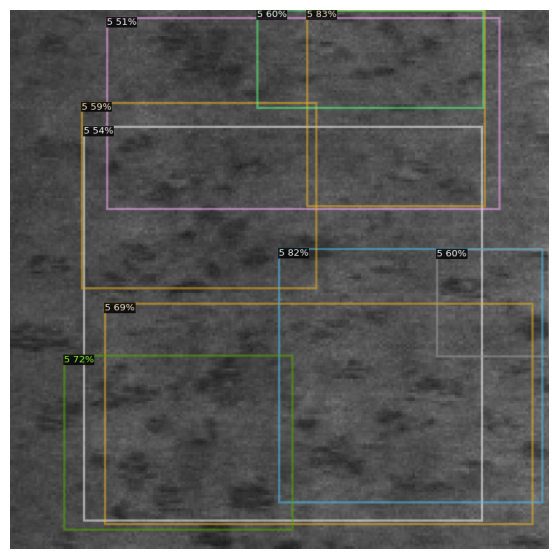

{'instances': Instances(num_instances=9, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[452.3002,   0.0000, 619.3512,  86.1926],
        [315.8541, 413.2754, 507.9560, 627.8176],
        [454.1249,  88.5419, 617.3486, 344.7039],
        [520.5541, 292.8784, 627.7988, 457.3274],
        [ 41.6402,   0.0000, 172.0099,  57.3657],
        [ 23.5154, 363.8493, 131.7796, 454.3606],
        [ 30.2770, 493.2570, 171.4866, 630.8227],
        [522.0370, 107.2063, 629.3722, 210.9210],
        [302.4725, 412.4998, 386.1833, 535.0842]], device='cuda:0')), scores: tensor([0.8181, 0.7878, 0.6853, 0.6838, 0.6746, 0.6460, 0.6429, 0.6127, 0.5026],
       device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')])}


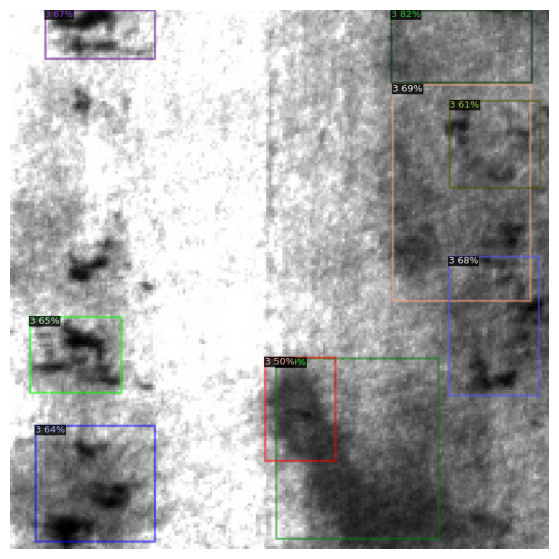

{'instances': Instances(num_instances=12, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[137.4708,  10.3797, 616.1398, 166.7719],
        [ 13.9315, 365.2632, 491.7030, 583.3539],
        [ 49.1108,  56.0189, 587.2469, 426.2698],
        [114.5300, 391.8577, 400.5874, 558.1730],
        [ 88.3443, 233.7164, 602.0165, 529.9714],
        [195.0436, 170.4396, 526.1793, 309.1014],
        [ 87.6848,  25.9063, 521.9504, 264.3196],
        [ 23.5036,  99.4261, 381.4897, 254.2209],
        [186.2021,   7.2208, 579.3849, 104.3183],
        [216.5380, 418.0352, 574.5114, 573.0547],
        [231.9680,  92.8761, 610.5189, 330.5709],
        [243.7997,  62.2368, 582.7834, 200.6044]], device='cuda:0')), scores: tensor([0.7856, 0.7496, 0.7352, 0.6159, 0.6159, 0.5954, 0.5588, 0.5548, 0.5474,
        0.5191, 0.5176, 0.5139], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


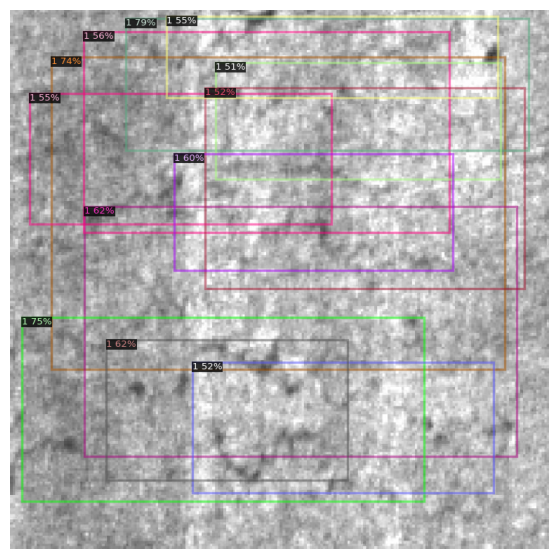

{'instances': Instances(num_instances=10, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[479.1440, 127.1471, 603.5242, 244.5820],
        [ 29.0524, 318.0471, 166.9246, 535.6264],
        [355.8617, 411.0225, 502.7056, 515.9252],
        [536.8542, 322.9765, 630.6400, 442.1905],
        [463.6604,   0.0000, 614.2433, 107.3000],
        [449.8110, 229.7176, 617.7593, 432.0562],
        [ 40.3759, 261.1975, 121.3356, 335.8293],
        [475.9452,  10.0198, 619.8262, 250.1069],
        [122.8981,   4.0455, 625.5498, 127.3458],
        [ 42.2672,  72.1705, 231.3129, 260.0670]], device='cuda:0')), scores: tensor([0.8992, 0.8886, 0.7511, 0.7182, 0.7155, 0.6903, 0.5846, 0.5597, 0.5319,
        0.5170], device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 1, 3], device='cuda:0')])}


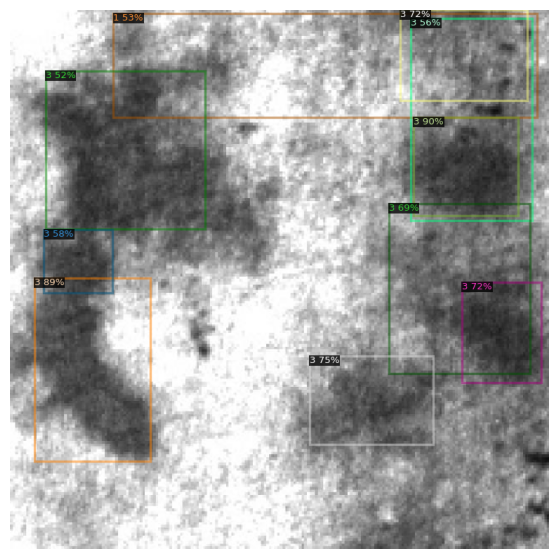

{'instances': Instances(num_instances=9, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 22.9265,  17.4779, 532.7734, 214.4590],
        [ 72.7109, 244.7057, 607.8087, 577.0472],
        [ 89.9948,  41.5117, 610.6198, 360.8293],
        [  7.6938, 413.4258, 299.5124, 546.9035],
        [ 60.5795, 422.1706, 606.1901, 605.4254],
        [220.8199, 165.6358, 607.3748, 464.1800],
        [ 27.7352,  39.1502, 267.8466, 191.6488],
        [273.3791, 329.4574, 516.7475, 476.3281],
        [ 39.9355,   9.2650, 598.5031, 129.1799]], device='cuda:0')), scores: tensor([0.7561, 0.7452, 0.6996, 0.6600, 0.6014, 0.5833, 0.5469, 0.5237, 0.5231],
       device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


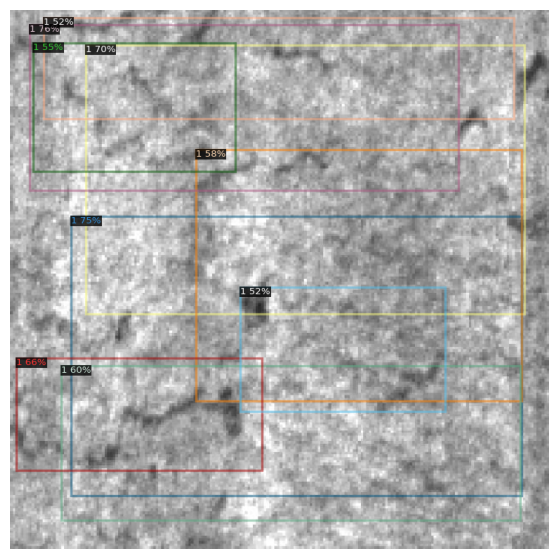

{'instances': Instances(num_instances=5, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[245.3131, 148.4761, 378.9964, 278.2023],
        [248.7808, 126.3852, 377.2411, 552.1737],
        [272.4662, 365.3392, 393.7799, 572.0510],
        [550.7411, 254.6674, 630.3934, 440.4731],
        [233.5335, 151.0016, 384.2376, 374.5557]], device='cuda:0')), scores: tensor([0.9481, 0.9426, 0.8529, 0.6230, 0.5657], device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3], device='cuda:0')])}


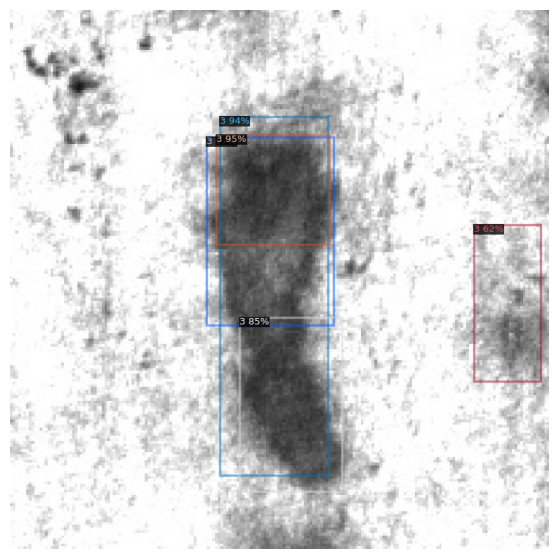

{'instances': Instances(num_instances=9, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 22.5328,   0.0000, 186.3332, 615.0322],
        [ 61.6946,   0.0000, 224.1033, 113.9343],
        [ 69.1793, 450.7410, 205.2299, 619.0970],
        [438.8287,   0.0000, 503.6029,  48.3538],
        [541.9737,  12.0032, 629.8947, 146.0617],
        [432.7152, 219.3490, 612.8737, 637.5590],
        [505.0607, 210.8774, 617.9328, 499.6271],
        [ 59.9517, 222.0149, 195.8090, 608.6475],
        [ 26.6698,   3.7994, 220.6114, 334.4873]], device='cuda:0')), scores: tensor([0.8902, 0.8643, 0.8495, 0.8230, 0.7598, 0.6766, 0.6747, 0.6588, 0.6120],
       device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')])}


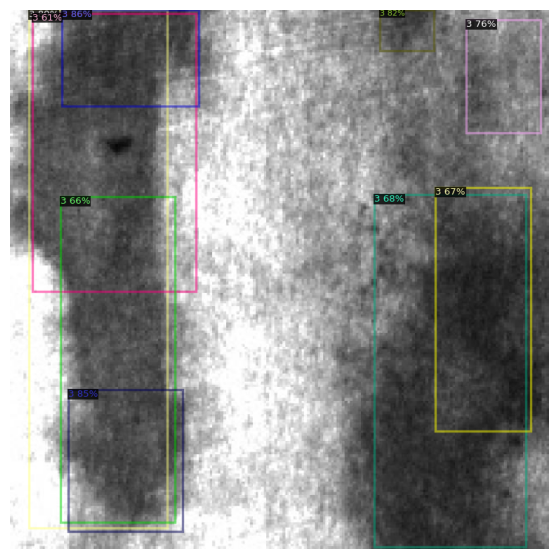

{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[444.7946, 127.8492, 488.6366, 268.8683],
        [430.3282,  40.6461, 482.4368, 247.1801],
        [423.6808, 327.2806, 483.0522, 495.4670],
        [425.8189, 105.6425, 488.3101, 544.3907]], device='cuda:0')), scores: tensor([0.7403, 0.6339, 0.6244, 0.5230], device='cuda:0'), pred_classes: tensor([2, 2, 2, 2], device='cuda:0')])}


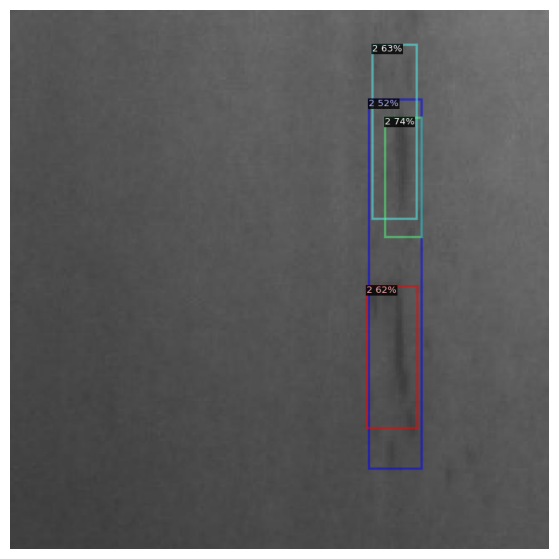

{'instances': Instances(num_instances=11, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 82.9074, 166.1058, 602.7065, 520.7309],
        [101.6162,  13.9438, 619.2693, 226.9661],
        [ 25.9182,   8.0342, 612.5798, 126.7170],
        [ 65.3179, 370.4833, 616.1743, 599.9243],
        [ 29.6740, 348.8351, 385.1536, 520.5527],
        [295.8636,  78.9700, 606.2041, 240.3300],
        [275.3211,  15.5445, 602.7037, 139.5152],
        [174.7133, 402.9348, 514.3823, 546.6683],
        [ 56.4617, 436.7682, 369.5394, 593.3167],
        [ 15.1158, 298.4060, 373.6021, 423.9649],
        [335.2802, 375.1032, 602.3279, 544.8795]], device='cuda:0')), scores: tensor([0.7056, 0.6442, 0.6366, 0.6337, 0.6160, 0.5909, 0.5407, 0.5348, 0.5319,
        0.5176, 0.5049], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')])}


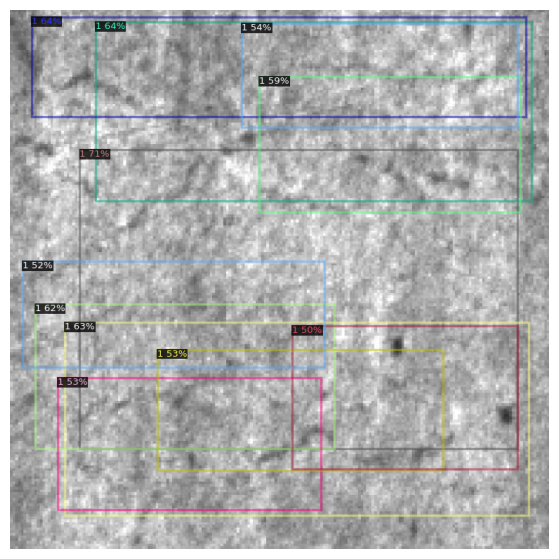

{'instances': Instances(num_instances=14, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 34.9944,   9.4539, 610.4828, 143.7658],
        [525.9181,   0.0000, 630.4272,  74.9184],
        [ 21.6637, 430.9952, 592.9448, 611.6692],
        [ 80.5625, 243.6220, 601.7081, 554.5861],
        [ 87.1027,  79.1858, 596.6928, 408.4318],
        [238.1266,   2.8548, 619.0407,  93.2548],
        [ 23.4579,  20.6301, 461.4215, 244.3110],
        [ 59.1690, 100.8566, 368.5670, 248.5704],
        [ 35.5212,  47.2961, 384.9175, 172.0795],
        [ 84.3772, 492.3417, 483.1671, 605.6982],
        [  4.0430, 307.6565, 395.3001, 579.2636],
        [242.8363, 383.7890, 591.9954, 515.2682],
        [  8.4691, 171.3586, 386.6392, 378.8049],
        [ 74.1807,  18.2322, 406.6538, 133.1706]], device='cuda:0')), scores: tensor([0.7345, 0.7136, 0.6795, 0.6642, 0.6484, 0.6447, 0.5907, 0.5658, 0.5472,
        0.5379, 0.5366, 0.5360, 0.5297, 0.5289], device='cuda:0'), pred_classes: tensor([

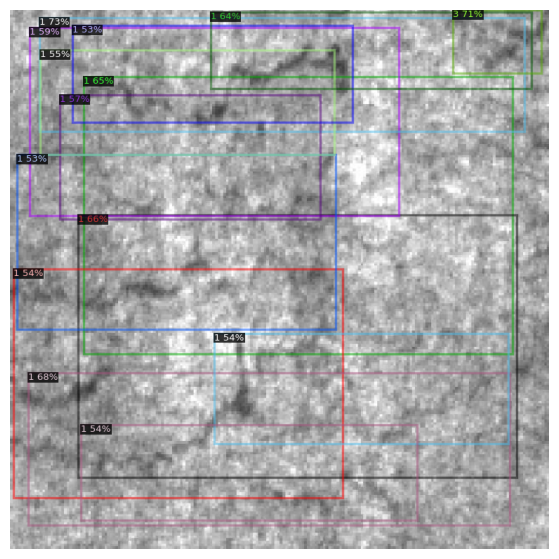

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 53.3423,   3.4843, 597.0651, 597.2278],
        [ 31.1576,  64.1673, 348.9099, 316.5601]], device='cuda:0')), scores: tensor([0.5623, 0.5020], device='cuda:0'), pred_classes: tensor([4, 1], device='cuda:0')])}


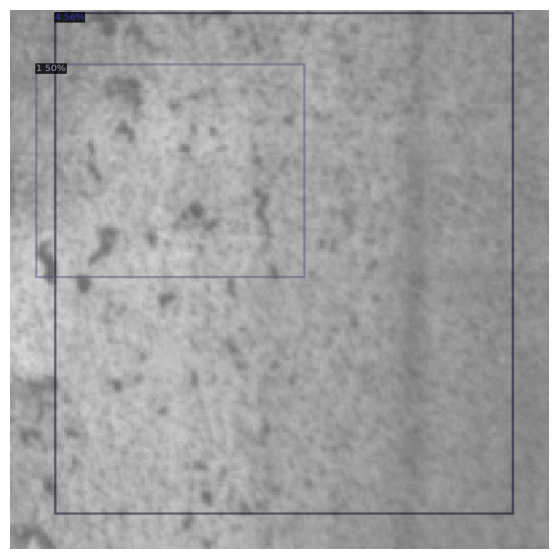

{'instances': Instances(num_instances=6, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[115.2597,  16.2667, 613.9324, 201.1735],
        [180.6794, 424.4608, 614.7386, 608.6389],
        [110.7329,  83.6514, 600.5773, 358.7724],
        [ 59.3542, 225.3707, 613.8019, 594.2253],
        [ 22.1497,   4.1511, 499.5745,  95.6362],
        [ 34.9358, 331.2562, 365.5157, 503.5379]], device='cuda:0')), scores: tensor([0.6358, 0.6150, 0.5896, 0.5874, 0.5805, 0.5490], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1, 1], device='cuda:0')])}


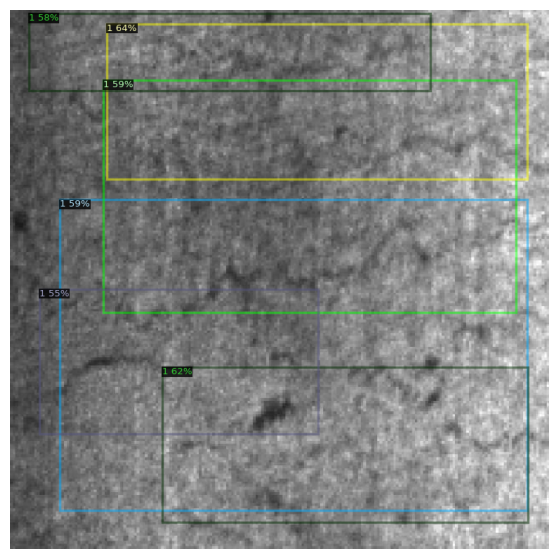

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[439.8673,   0.0000, 554.3604,  69.0015],
        [ 73.2433,   0.0000, 231.2852, 100.0239]], device='cuda:0')), scores: tensor([0.7722, 0.5834], device='cuda:0'), pred_classes: tensor([3, 3], device='cuda:0')])}


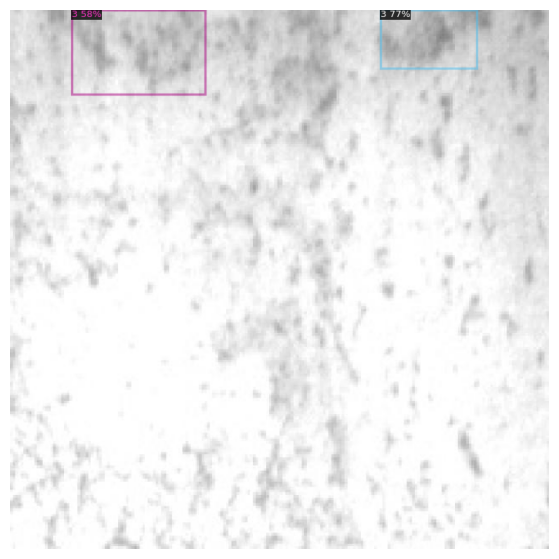

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[296.9428,   0.0000, 616.8051, 319.8276],
        [191.5844, 248.8610, 612.6003, 509.1535],
        [231.6551,   0.0000, 624.7902, 168.8623]], device='cuda:0')), scores: tensor([0.8283, 0.8153, 0.7243], device='cuda:0'), pred_classes: tensor([5, 5, 5], device='cuda:0')])}


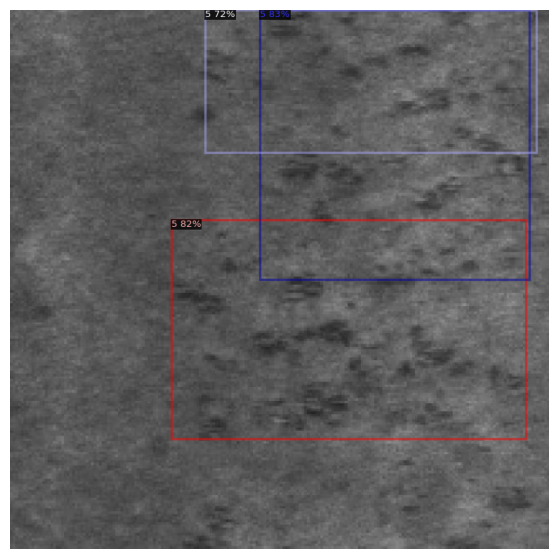

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 27.1905,   0.0000, 603.2487, 594.9915]], device='cuda:0')), scores: tensor([0.8018], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


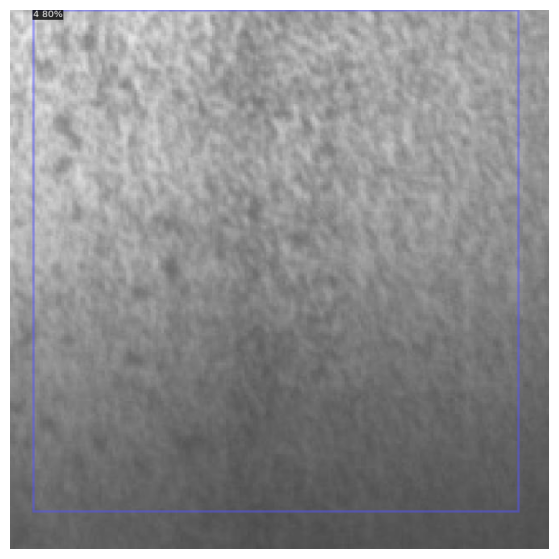

In [ ]:
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)
count=0
for img in glob.glob('/content/NEUDET-Steel-Surface-Defects-4/valid/*.jpg'):
  if count ==25:
    break
  inputs = cv2.imread(img)
  outputs = predictor(inputs)
  print(outputs)
  v = Visualizer(inputs[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
  plt.figure(figsize=(10, 7))
  plt.imshow(out.get_image())
  plt.axis('off')
  plt.show()

  count+=1

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")


print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`
# trainer.test()

[10/10 12:05:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[10/10 12:05:03 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/10 12:05:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 12:05:03 d2.data.datasets.coco]: Loaded 368 images in COCO format from /content/NEUDET-Steel-Surface-Defects-4/valid/_annotations.coco.json
[10/10 12:05:03 d2.data.build]: Distribution of instances among all 7 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| steel-surfa.. | 0            |    crazing    | 162          |   inclusion   | 177          |
|    patches    | 193          | pitted_surf.. | 87           | rolled-in_s.. | 132          |
|   scratches   | 133          |               |              |               |              |
|     total     | 884          |             

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import cv2
import random
import gc
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances

# Set up logger
setup_logger()

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.NUM_CLASSES = 7
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

# Set up confusion matrix
conf_mat = np.zeros((cfg.MODEL.RETINANET.NUM_CLASSES, cfg.MODEL.RETINANET.NUM_CLASSES))

# Process batches
for d in DatasetCatalog.get("my_dataset_test"):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"]

    for pred_class, pred_score, pred_box, gt_class in zip(
        instances.pred_classes, instances.scores, instances.pred_boxes, [d["annotations"][0]["category_id"]]
    ):
        conf_mat[gt_class, pred_class] += 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#hh
# ...
conf_mat_normalized = np.round(conf_mat / conf_mat.max(), 2)
# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=MetadataCatalog.get("my_dataset_train").thing_classes, yticklabels=MetadataCatalog.get("my_dataset_train").thing_classes, mask=(conf_mat_normalized==0), annot_kws={"fontsize": 8})
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

NameError: name 'conf_mat' is not defined

In [ ]:
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/Crack_V1-2/valid/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/24 09:51:47 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/24 09:51:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/24 09:51:47 d2.data.datasets.coco]: Loaded 147 images in COCO format from /content/Crack_V1-2/valid/_annotations.coco.json
[09/24 09:51:47 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   crack    | 0            |  b_defect  | 34           |  c_defect  | 41           |
|  m_defect  | 10           |  w_defect  | 6            |            |              |
|   total    | 91           |            |              |            |              |
[09/24 09:51:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[09/24 09:51:48 d2.evaluation.evaluator]: Inference done 11/147. Dataloading: 0.0028 s/iter. Inference: 0.0766 s/iter. Eval: 0.0003 s/iter. Total: 0.0796 s/iter. ETA=0:00:10
[09/24 09:51:53 d2.evaluation.evaluator]: Inference done 73/147. Dataloading: 0.0029 s/iter. Inference: 0.0781 s/iter. Eval: 0.0002 s/iter. Total: 0.0814 s/iter. ETA=0:00:06
[09/24 09:51:58 d2.evaluation.evaluator]: Inference done 134/147. Dataloading: 0.0033 s/iter. Inference: 0.0782 s/iter. Eval: 0.0002 s/iter. Total: 0.0818 s/iter. ETA=0:00:01
[09/24 09:51:59 d2.evaluation.evaluator]: Total inference time: 0:00:11.634302 (0.081932 s / iter per device, on 1 devices)
[09/24 09:51:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.078138 s / iter per device, on 1 devices)
[09/24 09:51:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/24 09:51:59 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[09/24 09:51:59 d2.evaluation.coco